# Стартап - **продажа продуктов питания**.   
##### Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно.

#### `Цель:` Разобраться в поведении пользователей мобильного приложения. Выяснить, какой шрифт лучше. 

#### `Задача:` Проанализировать 3 группы пользователей: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми.   
**Принять решение по результатам A/A/B-теста.**  

#### `Основные вопросы исследования:`   
- изучить воронку продаж  
- изучить маршрут пользователя до покупки  
- проанализировать шаги воронки продаж   
- проанализировать причины потерь пользователей  
- исследовать результаты A/A/B-эксперимента  
- сформировать решение по результатам A/A/B-теста  
  
#### `Данные:` Каждая запись в логе — это действие пользователя, или событие.  

#### `Описание данных:`    
 ##### `Файл /datasets/logs_exp.csv.:`  
  
`EventName` —  название события  
`DeviceIDHash` —  уникальный идентификатор пользователя  
`EventTimestamp` —  время события  
`ExpId` —  номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная  

#### `Требования к исследованию:`  

Подготовить данные  
  
Изучить и проверить данные   
  
Изучить воронку событий   

Изучить результаты эксперимента   

Сформулировать решение по результатам эксперимента

## Часть 1. Изучение общей информации

### Загрузка данных и подготовка к анализу

**Путь к файлу**

- /datasets/logs_exp.csv. [Скачать датасет](https://code.s3.yandex.net/datasets/logs_exp.csv.)


### Получение данных

In [1]:
#импорт библиотек
import pandas as pd
import scipy.stats as stats
import datetime as dt
from scipy import stats as st
import numpy as np
import math as mth
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import warnings
import pathlib
from pathlib import Path
from plotly import graph_objects as go
import plotly.express as px

# не показывать предупреждения
from pandas.plotting import register_matplotlib_converters
import warnings
warnings.filterwarnings('ignore')

from termcolor import cprint # жирный шрифт

# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()

pd.set_option('max_colwidth', None) # вывод всех символов в записях

In [6]:
# загрузка датасета

try:
    data = pd.read_csv('/datasets/logs_exp.csv', sep = '\t')  # чтение файла с данными и сохранение в data
except:
    data = pd.read_csv('https://code.s3.yandex.net//datasets/logs_exp.csv', sep = '\t')  
sns.set()

## Часть 2. Подготовка данных

### Изучение данных

In [7]:
# функция для изучения данных
def df_analysis(df):
    print('_________________________________________________________________________________________________________')
    print(' ')
    cprint('Вывод 2 строк таблицы с начала и с конца с заголовками', 'green', attrs=['bold'])
    display(df.head(2), df.tail(2))
    print('_________________________________________________________________________________________________________')
    print(' ')
    cprint('Запрос всех атрибутов', 'green', attrs=['bold'])
    print(' ')
    print(df.info())
    print('_________________________________________________________________________________________________________')    
    print(' ')
    cprint('Числовое описание данных', 'green', attrs=['bold'])
    print(' ')
    print(df.describe().T.round(1))
    print('_________________________________________________________________________________________________________') 
    print(' ')
    cprint('Пропущенные значения', 'green', attrs=['bold'])
    print(' ')
    df_pass = pd.DataFrame(df.isna().sum().sort_values(ascending=False))
    df_pass.columns = ['pass']
    df_pass['perc, %'] = (df_pass['pass']/len(df)*100).round(1) 
    print(df_pass) 
    print('_________________________________________________________________________________________________________')
    print(' ')
    cprint('Количество явных дубликатов', 'green', attrs=['bold'])
    print(' ')
    print(df.duplicated().sum())
    print('_________________________________________________________________________________________________________')
    print(' ')
    cprint('Общая обзорная гистограмма для столбцов с числовыми данными', 'green', attrs=['bold'])
    print(' ')
    df.hist(figsize=(10, 5))
    plt.show()
    print('_________________________________________________________________________________________________________')

_________________________________________________________________________________________________________
 
Вывод 2 строк таблицы с начала и с конца с заголовками


EventName         DeviceIDHash  EventTimestamp  ExpId
0  MainScreenAppear  4575588528974610257      1564029816    246
1  MainScreenAppear  7416695313311560658      1564053102    246

EventName         DeviceIDHash  EventTimestamp  ExpId
244124    MainScreenAppear  5746969938801999050      1565212498    246
244125  OffersScreenAppear  5746969938801999050      1565212517    246

_________________________________________________________________________________________________________
 
Запрос всех атрибутов
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None
_________________________________________________________________________________________________________
 
Числовое описание данных
 
                   count          mean           std           min  \
DeviceIDHash    244126.0  4.627568e+18  2.642425e+18  6.888747e+15   
EventTimestamp  244126.0  1.564914e+09  1.771343e+05  1.564030e+09   
ExpId           244126.0  2.470000e+02  8.000000e-01  2.460000e+02   

                 

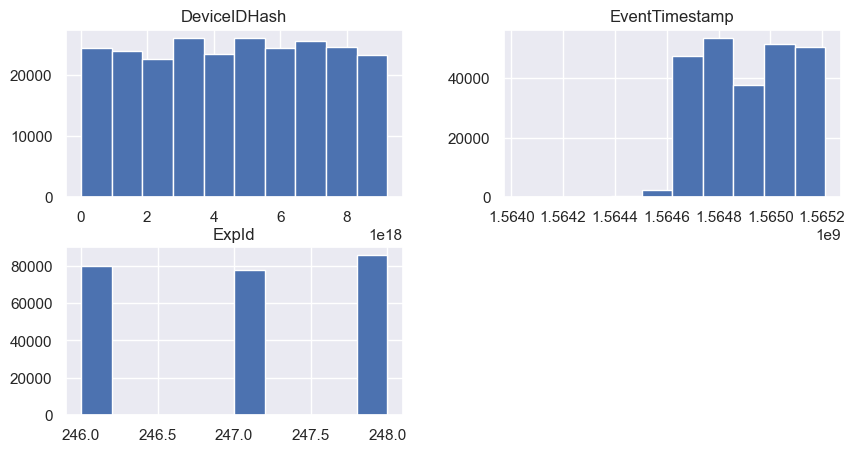

_________________________________________________________________________________________________________


In [8]:
df_analysis(data) # применение функции к нужному датафрейму

In [9]:
# код для просмотра уникальных значений
a = data['EventName'].unique()
#display(a)
display(sorted(a))

['CartScreenAppear',
 'MainScreenAppear',
 'OffersScreenAppear',
 'PaymentScreenSuccessful',
 'Tutorial']

In [10]:
a = data['ExpId'].unique()
display(sorted(a))

[246, 247, 248]

**Вывод по data:**  
  
- заменить названия заголовков к более удобным
- выявлено 413 дубликатов, удалить    
- EventTimestamp преобразовать к формату datetime 
- добавить отдельный столбец дат
- пропущенные значения отсутствуют  
- уникальные события:  
  **CartScreenAppear** - представление экрана корзины  
  **MainScreenAppear** - представление основного экрана     
  **OffersScreenAppear** - представление экрана предложения  
  **PaymentScreenSuccessful** - экран состоявшейся оплаты    
  **Tutorial** - инструкция  
- Id эксперимента:  
  **246** - 1 контрольная группа   
  **247** - 2 контрольная группа   
  **248** - 3 экспериментальная группа   

### Обработка данных.

In [11]:
data.columns = ['name_event', 'user_id', 'date_event', 'group']  # замена заголовков
data.columns # список названий всех столбцов - проверка

Index(['name_event', 'user_id', 'date_event', 'group'], dtype='object')

In [12]:
data=data.drop_duplicates().reset_index(drop=True)   # удаление явных дубликатов
data.duplicated().sum() # проверка на количество явных дубликатов

0

In [13]:
# преобразование данных о времени
data['date_event'] = pd.to_datetime(data['date_event'], unit='s')
data['date'] = data['date_event'].dt.normalize()
data['date_event_h'] = data['date_event'].dt.floor('h')
data['group'] = data['group'].astype('str')


In [14]:
# проверка изменений
data.info()
display(data.head(1))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   name_event    243713 non-null  object        
 1   user_id       243713 non-null  int64         
 2   date_event    243713 non-null  datetime64[ns]
 3   group         243713 non-null  object        
 4   date          243713 non-null  datetime64[ns]
 5   date_event_h  243713 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(1), object(2)
memory usage: 11.2+ MB


name_event              user_id          date_event group       date  \
0  MainScreenAppear  4575588528974610257 2019-07-25 04:43:36   246 2019-07-25   

         date_event_h  
0 2019-07-25 04:00:00

## Вывод

Данные подготовлены к работе  
- Пропущенных значений нет 
- Заменены заголовки  
- Дубликаты удалены  
- Добавлен столбец data  
- Преобразованы форматы дат к datetime64[ns]   
- Преобразован формат group к object для использования значения группы в строковом формате в функции z-теста

## Часть 3. Изучение и проверка данных

### Данные о логах

In [15]:
# подсчёт событий в логе
print('Всего событий в логе - {}.'.format(data['name_event'].count()))

Всего событий в логе - 243713.


In [16]:
# подсчёт пользователей в логе
print('Всего пользователей в логе - {}.'.format(data['user_id'].nunique()))

Всего пользователей в логе - 7551.


In [17]:
# среднее количество событий на пользователя
print('Cреднее количество событий на пользователя - {}.'.format(
    int(data.groupby('user_id')['name_event'].agg('count').median()))
     )

Cреднее количество событий на пользователя - 20.


Text(0.5, 1.0, 'Количество событий по пользователям')

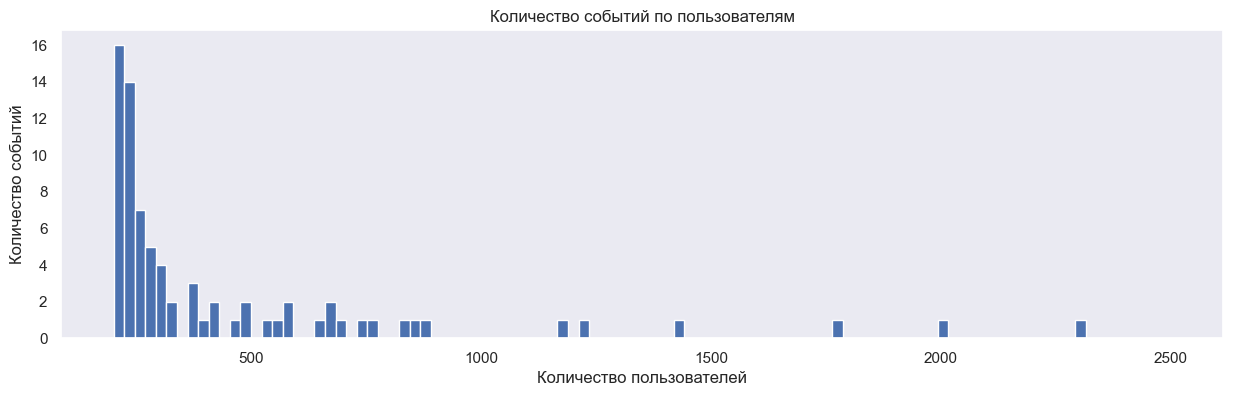

In [21]:
# гистограмма распределения количества событий по пользователямм
# (для понимания, какая из описательных статистик лучше охарактеризует распределение)
event_user = data.groupby('user_id')['name_event'].count()
plt.figure(figsize=(15,4))
plt.hist(event_user, bins=100, range=(200,2500)) 
plt.xlabel('Количество пользователей')
plt.grid()
plt.ylabel('Количество событий')
plt.title('Количество событий по пользователям')

### Данные о временном периоде

In [22]:
# максимальная и минимальная даты
print('\nДанные за период: начальная дата {}, конечная дата {}\n'.format(data['date_event'].min(), data['date_event'].max()))
print('Всего - {}'.format(data['date_event'].max()-data['date_event'].min()))


Данные за период: начальная дата 2019-07-25 04:43:36, конечная дата 2019-08-07 21:15:17

Всего - 13 days 16:31:41


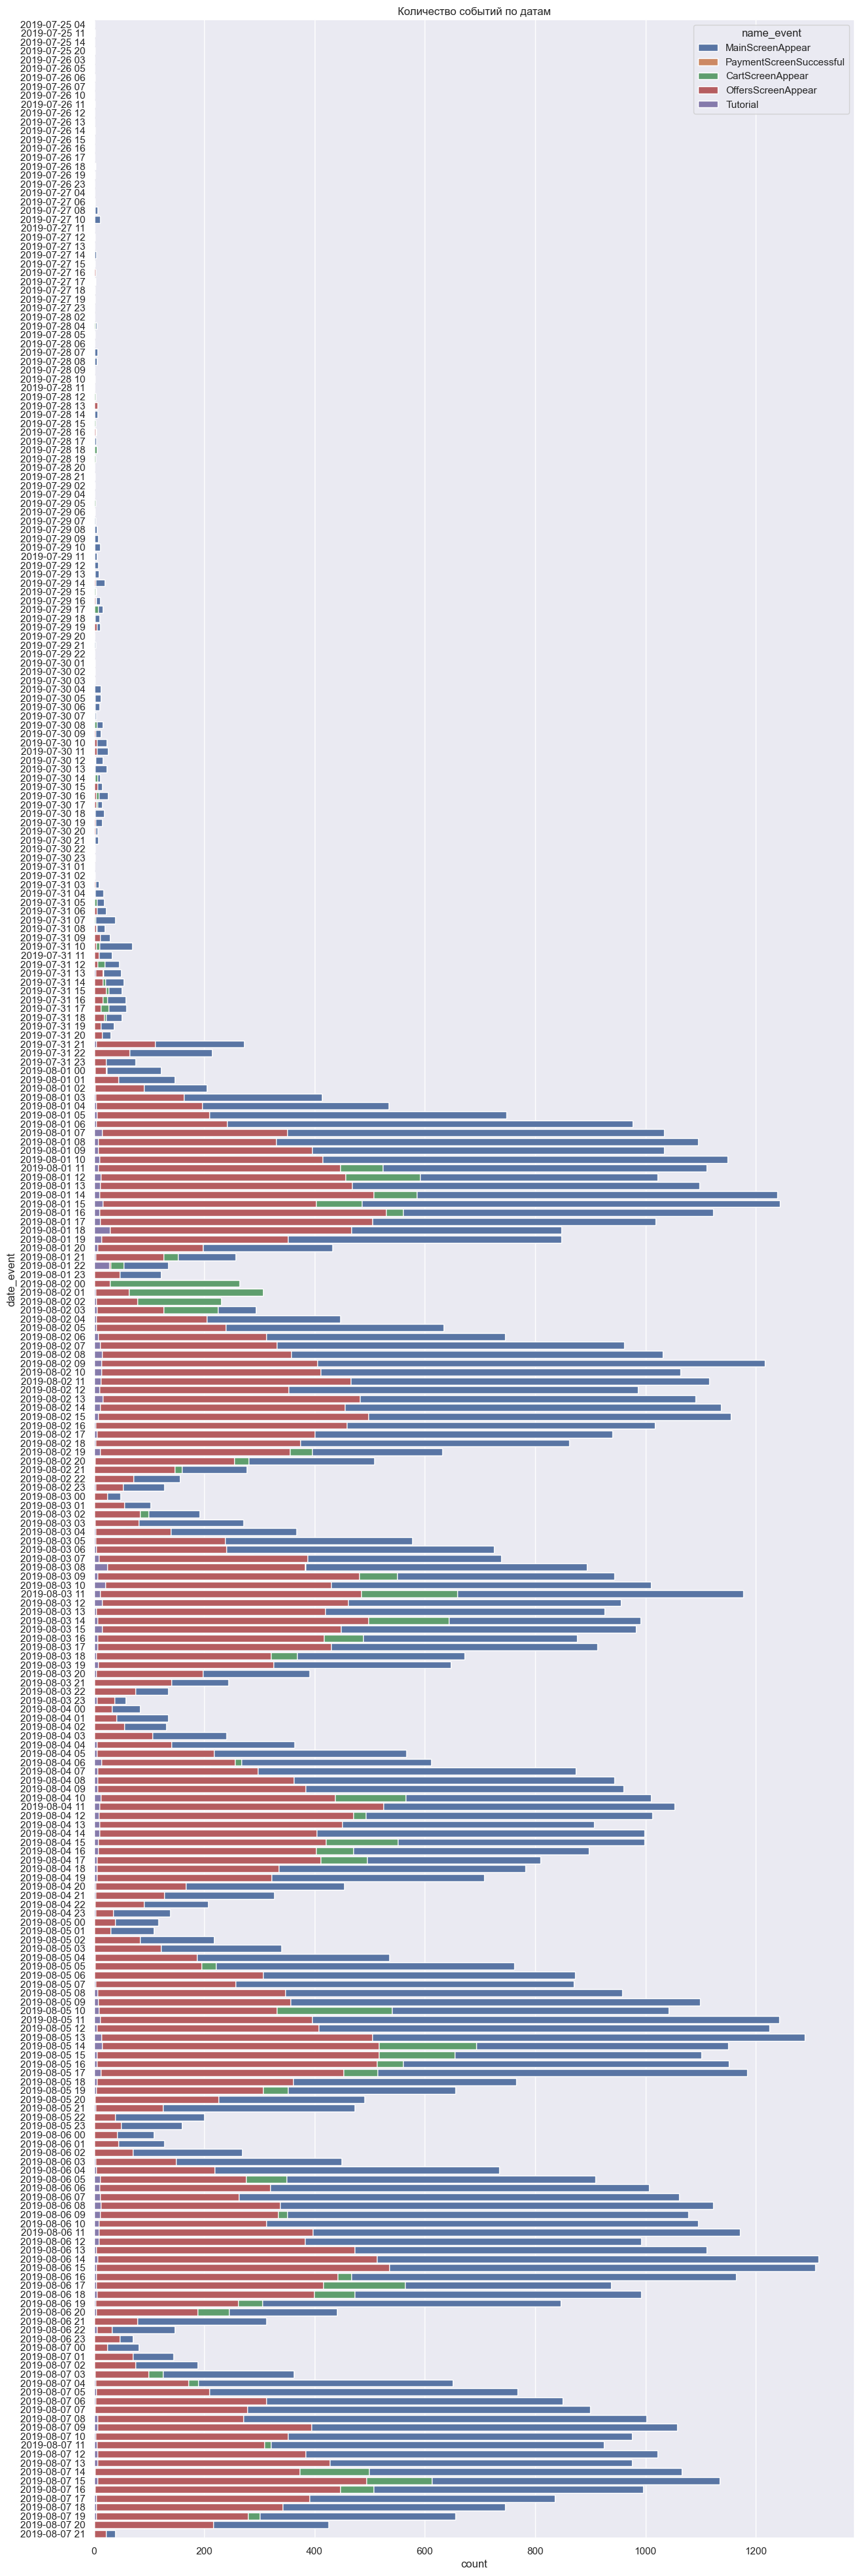

In [23]:
# гистограмма по дате и времени
plt.figure(figsize=(15, 50))
ax = sns.countplot(y=data['date_event'].dt.strftime('%Y-%m-%d %H'), hue='name_event', data=data, dodge=False)
ax.set_title('Количество событий по датам')
plt.show()

In [24]:
# количество событий по дням всего
pd.set_option('display.max_rows', None)
countByDays = (data.groupby('date', as_index=False).agg({'name_event': 'count'}))

countByDays.columns = ['date', 'count_event']
countByDays['fraction,%'] = round(countByDays['count_event']/ countByDays['count_event'].sum() *100, 2)
print(countByDays.sort_values(by='date', ascending=True))

         date  count_event  fraction,%
0  2019-07-25            9        0.00
1  2019-07-26           31        0.01
2  2019-07-27           55        0.02
3  2019-07-28          105        0.04
4  2019-07-29          184        0.08
5  2019-07-30          412        0.17
6  2019-07-31         2030        0.83
7  2019-08-01        36141       14.83
8  2019-08-02        35554       14.59
9  2019-08-03        33282       13.66
10 2019-08-04        32968       13.53
11 2019-08-05        36058       14.80
12 2019-08-06        35788       14.68
13 2019-08-07        31096       12.76


In [25]:
# определение момента, с которого данные полные
timestart = pd.to_datetime('2019-07-31 21:00:00')
# избавление от ненужных данных
good_data = data[(data['date_event'] >= timestart)]
print('Доля событий за первую неделю: {:.1%}'. format(len(data) / len(data[(data['date'] >= timestart)]) - 1))
print('Доля отброшенных событий: {:.1%}'. format(len(data) / len(good_data) - 1))

Доля событий за первую неделю: 1.2%
Доля отброшенных событий: 0.8%


In [26]:
# количество пользователей по дням всего
pd.set_option('display.max_rows', None)
countByUsers = (data.groupby('date', as_index=False).agg({'user_id': 'nunique'}))

countByUsers.columns = ['date', 'count_users']
countByUsers['fraction,%'] = round(countByUsers['count_users']/ countByUsers['count_users'].sum() *100, 2)
print(countByUsers.sort_values(by='date', ascending=True))

         date  count_users  fraction,%
0  2019-07-25            7        0.03
1  2019-07-26           22        0.08
2  2019-07-27           39        0.14
3  2019-07-28           69        0.25
4  2019-07-29          135        0.50
5  2019-07-30          296        1.09
6  2019-07-31          924        3.39
7  2019-08-01         3703       13.60
8  2019-08-02         3647       13.40
9  2019-08-03         3482       12.79
10 2019-08-04         3527       12.95
11 2019-08-05         3802       13.96
12 2019-08-06         3922       14.41
13 2019-08-07         3651       13.41


In [27]:
# количество пользователей в актуальном периоде
countByUsers1 = (good_data.groupby('date', as_index=False).agg({'user_id': 'nunique'}))
countByUsers1.columns = ['date', 'count_users']
print('Доля отброшенных поьзователей в сумме по дням: {:.1%}'. format(1 - sum(countByUsers1['count_users']) / sum(countByUsers['count_users'])))

Доля отброшенных поьзователей в сумме по дням: 4.9%


In [28]:
# размер потерянных данных после "очистки"
print('Количество отброшенных событий: ', "{0:.0f}".  format(len(data) - len(good_data)))
print('Доля отброшенных событий: ', "{0:.1%}".  format((len(data) - len(good_data))/len(data)))
print()
print('Количество отброшенных уникальных пользователей: ', "{0:.0f}".  
      format(len(data['user_id'].unique()) - len(good_data['user_id'].unique())))
print('Доля отброшенных уникальных пользователей: ', "{0:.1%}".  
      format((len(data['user_id'].unique()) - len(good_data['user_id'].unique()))/len(data['user_id'].unique())))

Количество отброшенных событий:  1989
Доля отброшенных событий:  0.8%

Количество отброшенных уникальных пользователей:  13
Доля отброшенных уникальных пользователей:  0.2%


Доля данных по событиям за первую неделю - это расчет за последнюю неделю июля полностью до конца дня. В таблице выше видно, что доля событий каждого дня занимает малые доли процента в общей картине и в сумме за неделю составляет 1,2%.  
Но т.к. в анализ включены события с 31 июля с 21.00 (на гистограмме видно, что активность заметно возросла именно с этого момента), получается, что отброшенными оказалось **0,8% (1 989) событий** из общего числа.  
  
Доля отброшенных уникальных пользователей - **0,2% - это 13 человек**.  

In [29]:
# актуальный временной промежуток
print('\nДанные за период: начальная дата {}, конечная дата {}\n'.
      format(good_data['date_event'].min(), good_data['date_event'].max()))
print('Всего - {}'.format(good_data['date_event'].max()-good_data['date_event'].min()))


Данные за период: начальная дата 2019-07-31 21:00:57, конечная дата 2019-08-07 21:15:17

Всего - 7 days 00:14:20


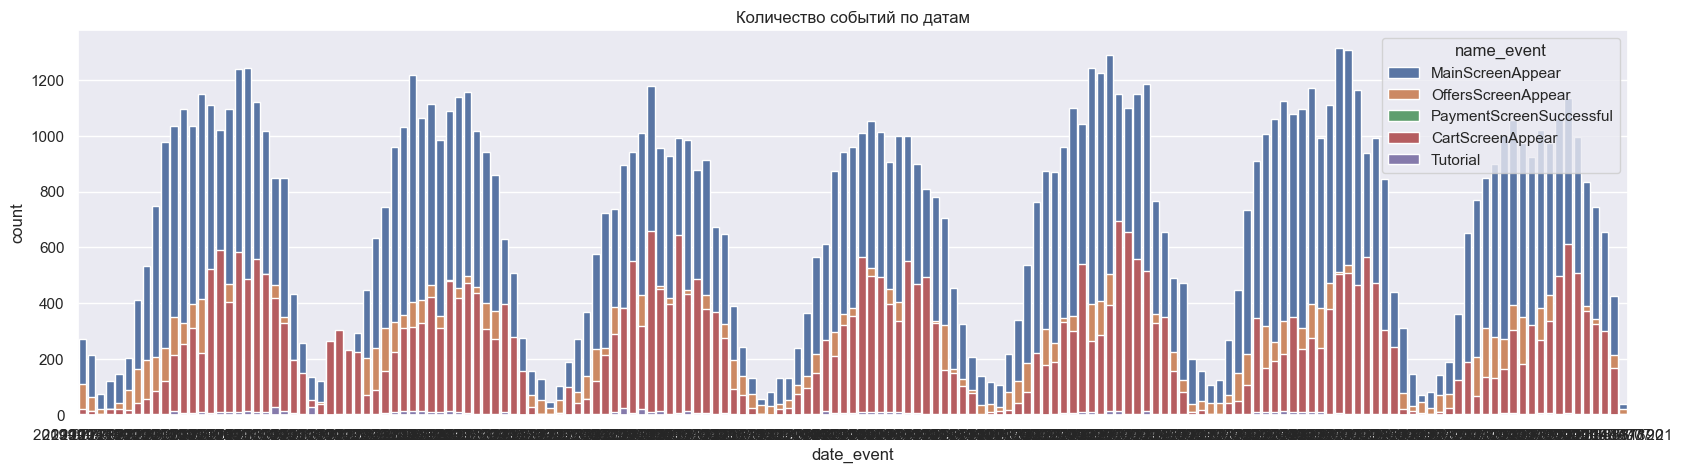

In [30]:
# гистограмма по дате и времени по очищенным данным
plt.figure(figsize=(20, 5))
ax = sns.countplot(x=good_data['date_event'].dt.strftime('%Y-%m-%d %H'), hue='name_event', data=good_data, dodge=False)
ax.set_title('Количество событий по датам')
plt.show()

In [31]:
# проверка наличия всех групп пользователей
countByGroups = (good_data.groupby('group', as_index=False).agg({'name_event': 'count'}))

countByGroups.columns = ['group', 'count_event']
countByGroups['fraction,%'] = round(countByGroups['count_event']/ countByGroups['count_event'].sum() *100, 2)
print(countByGroups.sort_values(by='group', ascending=True).head())

  group  count_event  fraction,%
0   246        79556       32.91
1   247        77293       31.98
2   248        84875       35.11


### Проверка данных и выводы

In [33]:
# группы 
group_246 = good_data.query('group == "246"') 
group_247 = good_data.query('group == "247"') 
group_248 = good_data.query('group == "248"')
# проверка id пользователей, попавших в обе группы - первый вариант
group_intersections1=list(np.intersect1d(group_246['user_id'], group_247['user_id']))
group_intersections2=list(np.intersect1d(group_247['user_id'], group_248['user_id']))
group_intersections3=list(np.intersect1d(group_246['user_id'], group_248['user_id']))
print(len(group_intersections1))
print(len(group_intersections2))
print(len(group_intersections3))

0
0
0


In [34]:
# проверка id пользователей, попавших в обе группы - второй вариант
doubles = (
good_data
    .groupby('user_id')
    .agg({'group' : 'nunique'})
    .query('group>1')
)
doubles

Empty DataFrame
Columns: [group]
Index: []

- в первичном датафрейме данные за период с 2019-07-25 04:43:36 до 2019-08-07 21:15:17 - почти 14 дней  
- в первую неделю накопленной информации - 1,2%, наиболее полные данные начали поступать с 21 часа 2019-07-31  
- **актуальным** определим период с 2019-07-31 21:00:57 по 2019-08-07 21:15:17 - 7 дней  
- после удаления отброшенных данных потерялось 0,8% (13 пользователей, 1 989 событий) информации, что допустимо и не исказит окончательный результат  
- деление экспериментальных групп (3) сохранилось примерно в равных долях, пользователи в группах не пересекаются


## Часть 4. Изучение воронки событий

### Обзор событий

In [35]:
print('Всего событий в логе - {}.'.format(good_data['name_event'].count()))
print()
print('Всего пользователей в логе - {}.'.format(good_data['user_id'].nunique()))
print()
print('Cреднее количество событий на пользователя - {}.'.format(
    int(good_data.groupby('user_id')['name_event'].agg('count').median()))
     )

Всего событий в логе - 241724.

Всего пользователей в логе - 7538.

Cреднее количество событий на пользователя - 19.


In [36]:
# обобщение данных по событиям
event = pd.pivot_table(good_data,
                       index=['name_event'],
                        values=['user_id'],
                        columns=['group'],
                        aggfunc='count',
                        margins=True)
# переименование столбцов
event.columns = ['_'.join(str(s).strip() for s in col if s) for col in event.columns]
event.reset_index(inplace=True)
event.columns = ['name_event', 'group_246', 'group_247', 'group_248', 'total']
# вид воронки по событиям в порядке убывания по частоте
event = event.sort_values(by=['total'], ascending=False)
# удаление итоговой строки 
event = event[(event['name_event'] != 'All')]
# вычисление долей событий в воронке в %
event['fraction_total,%'] = round(event['total']/ event['total'].max() * 100, 2)
event['fraction_246,%'] = round(event['group_246'] / event['total'] * 100, 2)
event['fraction_247,%'] = round(event['group_247'] / event['total'] * 100, 2)
event['fraction_248,%'] = round(event['group_248'] / event['total'] * 100, 2)
event

name_event  group_246  group_247  group_248   total  \
1         MainScreenAppear      37855      39294      40740  117889   
2       OffersScreenAppear      14829      15237      16465   46531   
0         CartScreenAppear      14697      12439      15207   42343   
3  PaymentScreenSuccessful      11858       9983      12110   33951   
4                 Tutorial        317        340        353    1010   

   fraction_total,%  fraction_246,%  fraction_247,%  fraction_248,%  
1            100.00           32.11           33.33           34.56  
2             39.47           31.87           32.75           35.39  
0             35.92           34.71           29.38           35.91  
3             28.80           34.93           29.40           35.67  
4              0.86           31.39           33.66           34.95

- В логах встречаются следующие события:  
   - **MainScreenAppear** - представление основного экрана (100%) 
   - **OffersScreenAppear** - представление экрана предложения (39%)
   - **CartScreenAppear** - представление экрана корзины (36%)    
   - **PaymentScreenSuccessful** - экран состоявшейся оплаты (29%)   
   - **Tutorial** - инструкция (0,9%)   
     
**Выводы по событиям:**  
- все события выстраиваются в последовательную цепочку (основной экран - экран с предложением - корзина - оплата - инструкция)  
- основная потеря событий происходит на первом этапе, с главного экрана более половины событий (61%) не переходят на экран с предложениями  
- с момента предложения до момента оплаты очень низкая потеря событий, что свидетельствует о качественном процессе доведения до оплаты  
- этап с инструкцией не приоритетный, используется по необходимости, переходов на этот этап очень мало  
- необходимо более детально разобраться, какие проблемы можно устранить, чтобы увеличить конверсию перехода на страницу с предложением  

### Воронка пользователей

In [37]:
# количество пользователей в каждой группе в изначальных данных
users_start = data.groupby('group')['user_id'].nunique()
users_start['246+247'] = users_start['246'] + users_start['247']
users_start['total'] = users_start['246'] + users_start['247']+ users_start['248']
users_start

group
246        2489
247        2520
248        2542
246+247    5009
total      7551
Name: user_id, dtype: int64

In [38]:
type(users_start['246'])

numpy.int64

In [39]:
# обобщение данных по пользователям, участвующих в событиях
users = good_data.pivot_table(index='name_event', values='user_id', columns='group', aggfunc=lambda x: len(
    x.unique())).reset_index()
# переименование столбцов
users.reset_index(inplace=True)
users.columns = ['', 'name_event', 'group_246', 'group_247', 'group_248']
users = users.drop(columns=[''])

# вычисление total пользователей
users['total_user'] = (users['group_246'] + users['group_247'] + users['group_248'])

# вид воронки по пользователям в порядке убывания по частоте
users = users.sort_values(by=['total_user'], ascending=False)

# переиндексация фрейма
users = users.reset_index(drop=True)

# вычисление долей пользователей в каждом событии воронки в %
users['fraction_total,%'] = round(users['total_user']/ users['total_user'].max() * 100, 2)

# вычисление доли пользователей, переходящих в следующий этап воронки в %
for i in range (0, len(users)):
    if i == 0:
        users.loc[i,'fraction_users,%'] = round(max(users['total_user'] / data['user_id'].nunique() * 100), 2)
    else: 
        users.loc[i, 'fraction_users,%'] = round(users.loc[i, 'total_user'] / 
                                                    users.loc[i - 1, 'total_user']* 100 , 2)
users

name_event  group_246  group_247  group_248  total_user  \
0         MainScreenAppear       2450       2479       2494        7423   
1       OffersScreenAppear       1542       1524       1531        4597   
2         CartScreenAppear       1266       1239       1231        3736   
3  PaymentScreenSuccessful       1200       1158       1182        3540   
4                 Tutorial        278        284        281         843   

   fraction_total,%  fraction_users,%  
0            100.00             98.30  
1             61.93             61.93  
2             50.33             81.27  
3             47.69             94.75  
4             11.36             23.81

In [40]:
# построение графика воронки по пользователям по данным total
users_1 = go.Figure(go.Funnel(
    y = users['name_event'],
    x = users['total_user'],
    textposition = 'inside',
    textinfo = 'value+percent initial')
    )

users_1.show()

In [41]:
# построение графика воронки пользователей по группам
users_3 = go.Figure()

users_3.add_trace(go.Funnel(
    name = '246',
    y = users['name_event'],
    x = users['group_246'],
    textinfo = 'value+percent initial'))

users_3.add_trace(go.Funnel(
    name = '247',
    y = users['name_event'],
    x = users['group_247'],
    textposition = 'inside',    
    textinfo = 'value+percent initial'))

users_3.add_trace(go.Funnel(
    name = '248',
    y = users['name_event'],
    x = users['group_248'],   
    textinfo = 'value+percent initial'))

users_3.show()

In [42]:
table = good_data[(good_data['name_event'] == 'MainScreenAppear')]
# среднее количество событий на пользователя на главной странице
print('Cреднее количество событий на пользователя на главном экране - {}.'.format(
    int(table.groupby('user_id')['name_event'].agg('count').median()))
     )

Cреднее количество событий на пользователя на главном экране - 11.


### Вывод:

- Распределение пользователей по воронке:  
   - **MainScreenAppear** - представление основного экрана (100%) 
   - **OffersScreenAppear** - представление экрана предложения (62%)
   - **CartScreenAppear** - представление экрана корзины (50%)    
   - **PaymentScreenSuccessful** - экран состоявшейся оплаты (48%)   
   - **Tutorial** - инструкция (11%)   
     
**Выводы по воронке по пользователям:**  
- все события выстраиваются в последовательную цепочку (основной экран - экран с предложением - корзина - оплата - инструкция)    
- основная потеря пользователей происходит на первом этапе, с главного экрана 38% пользователей не доходят до экрана с  предложениями  
- с момента предложения до момента оплаты очень низкая потеря клиентов, что свидетельствует о качественном процессе доведения до оплаты  
- среднее количество событий на пользователя на главной странице - 11, общее значение 19, это говорит о том, значение средней величины формируется преимущественно из значений главного экрана и, если изменть результативность конверсии стартовой страницы, то пользователи, которых можно было бы удержать, могли бы существенно повысить количество событий на стадии просмотра предложения, тогда % дошедших до оплаты был бы существенно выше.
- очевидна проблема на главной странице, где теряется основная масса пользователей, только 62% переходят на этап с предложением 
- от экрана с предложением к экрану с корзиной переходит 81% пользователей 
- от экрана с корзиной к оплате переходит 95% пользователей  
- почти половина пользователей (48%) доходит до стадии оплаты  


**Выводы по группам пользователей:**  
- распределение пользователей в группах по долям после отброшенных данных равномерное (почти одинаковое)  
- событие об обращении к инструкции можно считать малозначимым для данной аналитики и его в дальнейшем можно исключить, т.к. только 11% пользователей переходят на данную стадию и делают это однократно   

## Часть 5. Изучение результатов эксперимента

In [43]:
# вывод необходимых данных по пользователям в группах, которые участвовали в событиях
users_expn = users[(users['name_event'] != 'Tutorial')]
users_expn['sum_246_247'] = users_expn['group_246'] + users_expn['group_247']
users_exp = users_expn[['name_event', 'group_246', 'group_247', 'sum_246_247', 'group_248']].sort_values(by=['group_248'], ascending=False)
users_exp.columns = ['name_event', '246', '247', '246+247', '248']
users_exp

name_event   246   247  246+247   248
0         MainScreenAppear  2450  2479     4929  2494
1       OffersScreenAppear  1542  1524     3066  1531
2         CartScreenAppear  1266  1239     2505  1231
3  PaymentScreenSuccessful  1200  1158     2358  1182

### А/А-эксперимент

**Критерии для проведения теста:**
- количество пользователей в группах различается не более, чем на 1%
- данные об одном и том же  
- группы неизменны до конца теста для однозначной интерпретации резальтата  
- различие ключевых метрик по группам не должно превышать 1% и не иметь статистической значимости  

**Нулевая гипотеза:** ***распределение долей*** групп 246 и 247 одинаковое, статистически значимых отличий нет.  
**Альтернативная гипотеза:** ***распределение долей*** групп 246 и 247 различное, статистически значимые отличия есть.

In [44]:
# варианты критического уровня статистической значимости
alpha = 0.01
alpha1 = 0.05

In [45]:
def ztest(event_1, event_2, total_1, total_2):
    share_1 = event_1 / total_1
    share_2 = event_2 / total_2
    share_combined = (event_1 + event_2) / (total_1 + total_2)
    diff = share_1 - share_2

    z_value = diff / (share_combined * (1 - share_combined) * (1/total_1 + 1/total_2)) ** 0.5
    dist = stats.norm(0, 1)
    return 2 * (1 - dist.cdf(abs(z_value)))

def ztest_all(group1, group2, exp, start, alpha):
    for i in users_exp.index:
    
        p_value = round(ztest(exp[group1][i], exp[group2][i], start[group1], start[group2]), 4)
        print('{} p-значение: {}'.format(users_exp['name_event'][i], p_value))
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')

In [46]:
ztest_all('246', '247', users_exp, users_start, alpha)

MainScreenAppear p-значение: 0.8653
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.2836
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.2297
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.1091
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [47]:
users_exp

name_event   246   247  246+247   248
0         MainScreenAppear  2450  2479     4929  2494
1       OffersScreenAppear  1542  1524     3066  1531
2         CartScreenAppear  1266  1239     2505  1231
3  PaymentScreenSuccessful  1200  1158     2358  1182

In [48]:
type(users_start)

pandas.core.series.Series

**Вывод:**  

Для проведения А/А-теста важно, чтобы контрольные группы были максимально одинаковыми, поэтому уровень значимости принят за 1%.  
В проведённом тесте разница в пропорциях при данных размерах выборок недостаточна, чтобы говорить о статистически значимом различии.  
Группы 246 и 247 выбраны корректно, считаем их контрольными. 


### Выбор шрифта

**Нулевая гипотеза:** ***распределение долей*** групп 246 и 248 одинаковое, статистически значимых отличий нет.  
**Альтернативная гипотеза:** ***распределение долей*** групп 246 и 248 различное, статистически значимые отличия есть.

In [49]:
ztest_all('246', '248', users_exp, users_start, alpha1)

MainScreenAppear p-значение: 0.382
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.2098
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.0839
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.2236
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Нулевая гипотеза:** ***распределение долей*** групп 247 и 248 одинаковое, статистически значимых отличий нет.  
**Альтернативная гипотеза:** ***распределение долей*** групп 247 и 248 различное, статистически значимые отличия есть.

In [50]:
ztest_all('247', '248', users_exp, users_start, alpha1)

MainScreenAppear p-значение: 0.4794
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.8569
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.5983
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6966
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Нулевая гипотеза:** ***распределение долей*** групп 246+247 и 248 одинаковое, статистически значимых отличий нет.  
**Альтернативная гипотеза:** ***распределение долей*** групп 246+247 и 248 различное, статистически значимые отличия есть.

In [51]:
ztest_all('246+247', '248', users_exp, users_start, alpha1)

MainScreenAppear p-значение: 0.3544
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.4088
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.1934
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6353
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод:**  
  
Для проведения А/В-теста допустимый уровень значимости 5%.
В проведённых тестах разница в пропорциях при данных размерах выборок недостаточна, чтобы говорить о статистически значимом различии.
Это говорит о том, что изменение шрифта не оказало никакого влияния на поведение пользователей в экспериментальной группе.
А/В-тест можно считать законченным.

# Общий вывод.

Для принятия решения о внедрении изменения по замене шрифтов на стартовой странице приложения предоставлена информация за период с 2019-07-25 по 2019-08-07 (~ 14 дней). При обработке данных актуальным оказался период с **2019-07-31 21:00:57 по 2019-08-07 21:15:17 (7 дней)**. Потерянные данные составили 0,8% информации, что не может повлиять на итоговый результат.  
  
Первичный обзор деления на группы (2 контрольные и 1 экспериментальная) показал, что группы разделены корректно как по числу пользователей, так и почислу событий, что позволило продолжить эксперимент без корректировок.  
  
Последовательность событий в следующем виде (в порядке убывания): основной экран - экран с предложением - корзина - оплата - инструкция.

98% пользователей хотя бы раз заходили на главную страницу приложения.  
  
Самое популярное событие - представление основного экрана - 117 889 событий, 7 423 пользователя.  
Событие "оплата предложения" содержит в себе 33 951 событие и 3 540 пользователей. До конца доходит 48% пользователей (это 29% событий).  

На этапе перехода с главной страницы к странице с предложением происходит основная потеря пользователей -  38% пользователей и 61% событий. Далее по воронке потери адекватные. Рекомендовано более подробно изучить, что влияет на потерю пользователей приложения.  
  
Событие "инструкция" носит информационный характер, дошедшие до него пользователи совершают его в среднем 1 раз, поэтому в проведении эксперимента далее данное событие не исследовалось.  
  
**Проведено 16 экспериментов и проверено 16 гипотез.**   
  
Решено провести А/А-тест для того, чтобы оценить выборку, а также убедиться, что деление трафика на группы качественное, выбросы/аномалии отсутствуют и не повлияют на итоговый вывод, а также получить предварительный результат перед проведением А/В-теста. Уровень статистической значимости 1%, т.к. выборки контрольных групп в данном тесте должны быть максимально одинаковыми.   
  
Результат **А/А-теста** показал, что статистически значимого отличия в распределении контрольных групп нет, данные выбраны корректно, можно далее проводить А/В-тест.  
  
Для А/В-теста уровень статистической значимости установлен 5%, т.к. здесь уже не требуется такого точного результата.  
  
Результат **А/В-теста** показал, что статистически значимого отличия в распределении групп нет, что говорит о том, что изменение предложенного шрифта не оказало никакого влияния на поведение пользователей в экспериментальной группе. А/В-тест можно считать завершённым. 
